<a href="https://colab.research.google.com/github/EladGold/Emotion_Detection/blob/main/Final_Project_Naive_Architecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wandb --upgrade
!pip install hiddenlayer --upgrade

     |████████████████████████████████| 2.0MB 18.7MB/s 
     |████████████████████████████████| 102kB 12.9MB/s 
     |████████████████████████████████| 163kB 41.5MB/s 
     |████████████████████████████████| 133kB 50.3MB/s 
     |████████████████████████████████| 71kB 11.5MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6489 sha256=3b2decd914df87777bd1e9d1326e507d6f3eeffb6a4b6ea6d90c5403ac30d362
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8786 sha256=e12b694cc5e8b2f7388f44eb91869a4c8e7b276097f985539a1e60d9a81fcea3
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
Successfully built subprocess32 pathtools


In [2]:
# Importing relevant Libraries

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time
import os
import wandb
import numpy as np
import pandas as pd



In [3]:
# Choose GPU if available, else CPU
if torch.cuda.is_available():
    proc = torch.device('cuda')
else:
    proc = torch.device('cpu')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

!pip install -q kaggle
!pip install -q kaggle-cli
!mkdir -p ~/.kaggle
# !cp "/gdrive/MyDrive/FinalProject/kaggle.json" ~/.kaggle/
!cp "/content/drive/MyDrive/FinalProject/kaggle.json" ~/.kaggle/

!cat ~/.kaggle/kaggle.json 
!chmod 600 ~/.kaggle/kaggle.json
# For competition datasets
!kaggle datasets download -d astraszab/facial-expression-dataset-image-folders-fer2013

Mounted at /content/drive
     |████████████████████████████████| 81kB 8.8MB/s 
     |████████████████████████████████| 4.2MB 36.8MB/s 
     |████████████████████████████████| 51kB 8.3MB/s 
     |████████████████████████████████| 143kB 43.3MB/s 
     |████████████████████████████████| 112kB 57.5MB/s 
  ERROR: Failed building wheel for lxml
    Running setup.py install for lxml ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-acs_omli/lxml/setup.py'"'"'; __file__='"'"'/tmp/pip-install-acs_omli/lxml/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-bxjpmprz/install-record.txt --single-version-externally-managed --compile Check the logs for full command output.
{"username":"eladgold","key":"289c3ed2467eb873ab76ec0bad2e9361"}Downloadi

In [5]:
# Complete path to storage location of the .zip file of data
zip_path = '../content/drive/MyDrive/facial-expression-dataset-image-folders-fer2013.zip'
# Check current directory (be sure you're in the directory where Colab operates: '/content')
os.getcwd()
# Copy the .zip file into the present directory
!cp '{zip_path}' .
# Unzip quietly 
data = !unzip -q 'facial-expression-dataset-image-folders-fer2013.zip'
# View the unzipped contents in the virtual machine
os.listdir()

cp: cannot stat '../content/drive/MyDrive/facial-expression-dataset-image-folders-fer2013.zip': No such file or directory


['.config',
 'data',
 'drive',
 'facial-expression-dataset-image-folders-fer2013.zip',
 'sample_data']

In [6]:
data_dir = '../content/data'

train = data_dir + '/train'                           # Contains training images
test = data_dir + '/test'                           # Contains test images

val = data_dir + "/val"                               # Contains validation images
print(os.listdir(data_dir))
classes = os.listdir(train)
print(classes)

train_0 = '../content/data/train/0'
train_1 = '../content/data/train/1'
train_2 = '../content/data/train/2'
train_3 = '../content/data/train/3'
train_4 = '../content/data/train/4'
train_5 = '../content/data/train/5'
train_6 = '../content/data/train/6'

paths = [train_0, train_1, train_2 ,train_3 ,train_4 ,train_5 ,train_6]


['val', 'test', 'train']
['4', '3', '2', '5', '1', '0', '6']


In [7]:
def countSamples (path):
  file_count = 0
  for _, dirs, files in os.walk(path):
      file_count += len(files) 
  return file_count

def getWeights (paths):
  weights = []
  for path in paths:
    weights.append(1./countSamples(path))
  return weights

weights = getWeights (paths)
print (weights)

[0.00025031289111389235, 0.0022935779816513763, 0.000244081034903588, 0.0001386001386001386, 0.00020703933747412008, 0.000315357931251971, 0.0002014098690835851]


In [8]:
transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ]
    )

train_data = torchvision.datasets.ImageFolder(train, transform)

for i in range(5):
  train_data = torchvision.datasets.ImageFolder(train, transform)

validation_data = torchvision.datasets.ImageFolder(val, transform)

In [9]:
train_data[0][1]

0

In [10]:
samples_weight = []
for i in range(len(train_data)):
  samples_weight.append(weights[train_data[i][1]])

In [11]:
print (len(samples_weight))
samples_weight = torch.tensor(samples_weight)

28709


In [12]:
print(len(train_data),len(validation_data))

28709 3589


In [13]:
print(train_data[0][0].shape)

torch.Size([3, 48, 48])


In [14]:
# Use dataloaders for train and test (batch size is batchSize)
batchSize = 64
sampler = torch.utils.data.WeightedRandomSampler(samples_weight, len(samples_weight))

trainloader = torch.utils.data.DataLoader(train_data, batch_size=batchSize,
                                           sampler = sampler)

testloader = torch.utils.data.DataLoader(validation_data, batch_size=batchSize,
                                         shuffle=False)

In [16]:
#@title 
class EmotionDetect (nn.Module):


#initialize the Neural network build. Expanding network
    def __init__(self, external_model = None):
        super(EmotionDetect, self).__init__()
        if external_model is None:
          external_model = torchvision.models.resnet50(pretrained= True)
        self.features = nn.Sequential(*list(external_model.children())[:-3])
        for i,p in enumerate(self.features.parameters()):
          p.requires_grad = False


        self.conv1 = nn.Conv2d(3, 64, 5)
        self.batch1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, 5)
        self.batch2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 5)


        
        self.fc1 = nn.Linear(16384, 4096)
        self.fc2 = nn.Linear(4096, 858)
        self.fc3 = nn.Linear(858, 70) 
        self.fc4 = nn.Linear(70, 7)

        self.dropout = nn.Dropout(0.4)
        self.dropout2 = nn.Dropout(0.2)

# The Forward propagation function for CNNFMnist
    def forward(self, x):

        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))


        x = torch.flatten(x, start_dim=1)

        x = self.fc1(x)
        x = self.dropout2(x)
        x = F.relu(x)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        h = x
        x = self.fc4(x)

        return h,x

In [17]:
# Initialize a new network
net = EmotionDetect().to(proc)



# define loss function
criterion = nn.CrossEntropyLoss()

# define the optimizer

optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# optimizer = torch.optim.SGD(net.parameters(), lr=0.002)





Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [18]:
# 1. Start a new run
wandb.init(project="final_proj", entity="eladg")

# 2. Save model inputs and hyperparameters
config = wandb.config
config.learning_rate = 0.001

# 3. Log gradients and model parameters
wandb.watch(net)    


<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [19]:
# A function that trains the NN with the GPU
# params epochs - number of epochs to train for
# returns the loss history of the train and test data
def trainingLoop (epochs):  
  loss_history_train = []
  running_loss_epoch = 0
  loss_history_test = []
  start_time = time.time()

  for epoch in range(epochs):  

      epoch_time = time.time()
      running_loss = 0.0
      for i, data in enumerate(trainloader, 0):

          # get the inputs
          inputs, labels = data
          
          inputs = inputs.to(proc)
          labels = labels.to(proc) 


          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs1, outputs2 = net(inputs)
          loss = criterion(outputs2, labels)
          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item()
          running_loss_epoch += loss.item()
          if (i+1) % 500 == 0:    
              print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 500))
              running_loss = 0.0

      # Appending the loss per epoch for the train and test data to the history arrays
      loss_history_train.append(running_loss_epoch/len(trainloader))
      test_res = (testNET())
      loss_history_test.append(test_res)
      wandb.log({"batchSize": batchSize, "loss": running_loss_epoch/len(trainloader),
                 "testAcc": test_res, "time per epoch": (time.time() - epoch_time)})
      running_loss_epoch = 0
      print("It took %s seconds for the epoch to run" % (time.time() - epoch_time))
      # 4. Log metrics to visualize performance

  print('Finished Training')
  print("It took %s seconds for the training to run" % (time.time() - start_time))
  return loss_history_train, loss_history_test

In [20]:
# A function that checks the test accuracy of the NN 
def testNET ():
  correct = 0
  total = 0
  running_loss = 0.0
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          images = images.to(proc) 
          labels = labels.to(proc) 
          

          outputs = net(images)
          loss = criterion(outputs[1], labels)
          running_loss += loss.item()
          _, predicted = torch.max(outputs[1].data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))
  wandb.log({"correctnessPercent": (100.0 * correct / total)})
  return running_loss/len(testloader)

Accuracy of the network on the test images: 8 %
It took 35.68516993522644 seconds for the epoch to run
Accuracy of the network on the test images: 18 %
It took 35.598899364471436 seconds for the epoch to run
Accuracy of the network on the test images: 30 %
It took 35.344191551208496 seconds for the epoch to run
Accuracy of the network on the test images: 32 %
It took 35.564157247543335 seconds for the epoch to run
Accuracy of the network on the test images: 34 %
It took 35.83364510536194 seconds for the epoch to run
Accuracy of the network on the test images: 37 %
It took 35.45170736312866 seconds for the epoch to run
Accuracy of the network on the test images: 41 %
It took 35.78543710708618 seconds for the epoch to run
Accuracy of the network on the test images: 43 %
It took 35.44851064682007 seconds for the epoch to run
Accuracy of the network on the test images: 44 %
It took 35.63278245925903 seconds for the epoch to run
Accuracy of the network on the test images: 42 %
It took 35.50

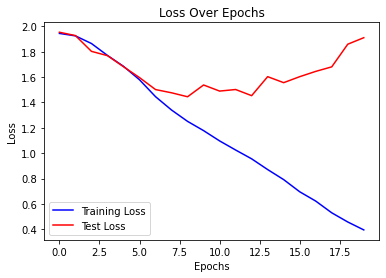

In [21]:
epochs = 20
loss_history_train, loss_history_test = trainingLoop(epochs)

plt.plot(range(epochs) , loss_history_train, 'blue')
plt.plot(range(epochs) ,loss_history_test, 'red')
plt.title("Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Training Loss', 'Test Loss']);
plt.show()

/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_helper.py:446: UserWarning: ONNX export mode is set to inference mode, but operator dropout is set to training  mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


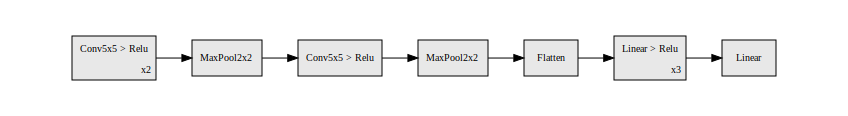

In [22]:
import hiddenlayer as hl
from google.colab import files
hl.build_graph(net, torch.zeros([64, 3, 48, 48]).to(proc))